Load Dataset

In [43]:
import numpy as np


In [44]:
data = np.genfromtxt('dataset/processed.cleveland.data', delimiter=',', dtype=str)
data[data == '?'] = np.nan
data = data.astype(float)

Remove rows with missing values

In [45]:
rows_without_nan = ~np.isnan(data).any(axis=1)

cleaned_data = data[rows_without_nan]

labels = cleaned_data[:, -1]

for i in range(len(labels)):
    if labels[i] > 0:
        labels[i] = 1

cleaned_data = cleaned_data[:, :-1]

print(cleaned_data)

[[63.  1.  1. ...  3.  0.  6.]
 [67.  1.  4. ...  2.  3.  3.]
 [67.  1.  4. ...  2.  2.  7.]
 ...
 [68.  1.  4. ...  2.  2.  7.]
 [57.  1.  4. ...  2.  1.  7.]
 [57.  0.  2. ...  2.  1.  3.]]


Standard Normalize

In [46]:
mean = np.mean(cleaned_data)
std_dev = np.std(cleaned_data)
z_score = (cleaned_data - mean) / std_dev

PCA

Explained Variance:  [7.46243578e-01 1.49787648e-01 8.57955289e-02 1.60023313e-02
 1.01307682e-03 3.30072242e-04 2.50801576e-04 2.22000205e-04
 1.76402998e-04 5.92782847e-05 4.75020518e-05 4.06039465e-05]


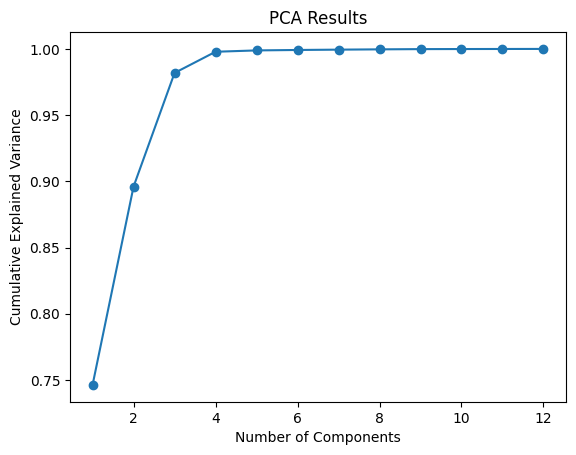

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=12)
principal_components =  pca.fit_transform(cleaned_data)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance: ", explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Results')
plt.show()


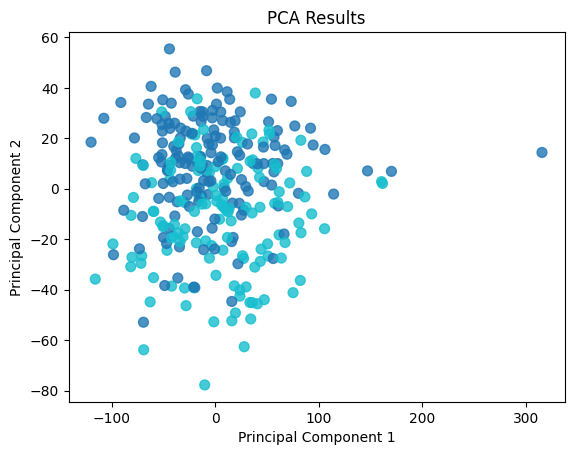

In [48]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='tab10', s=50, alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results')
plt.show()

In [49]:
from sklearn.metrics import silhouette_score
score = silhouette_score(cleaned_data, labels)
print("Silhouette: ", score)

Silhouette:  0.04435317118377064


In [50]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [51]:
eps_values = np.linspace(0.1, 20.0, 50)       # try 50 values from 0.1 to 20.0
min_samples_values = range(2, 11) 

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        db_labels = db.fit_predict(cleaned_data)
        # need at least 2 clusters (ignoring noise) to compute silhouette
        n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        if n_clusters < 2:
            continue

        score = silhouette_score(cleaned_data, db_labels)
        results.append((eps, min_s, score))
        if score > best_score:
            best_score = score
            best_params = (eps, min_s)

print(f"Best silhouette={best_score:.3f} with eps={best_params[0]:.3f}, min_samples={best_params[1]}")

Best silhouette=0.098 with eps=19.594, min_samples=6


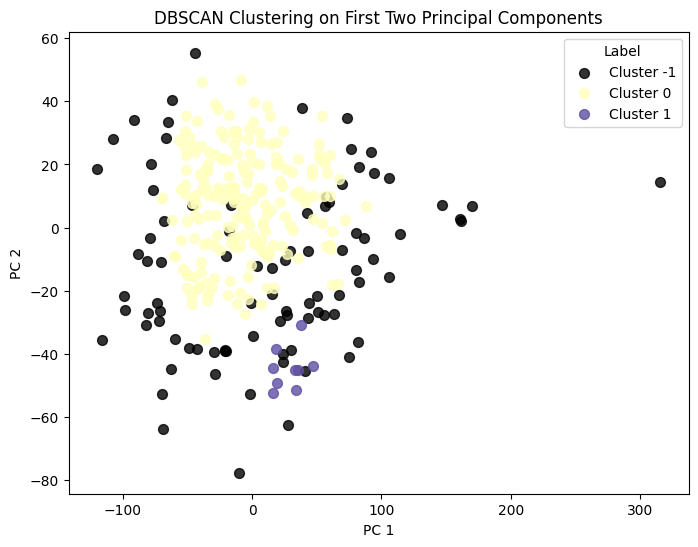

In [52]:


db_labels = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit_predict(cleaned_data)
# — or, to cluster in PC-space:
# labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(principal_components[:, :2])

# 3) Extract the first two PCs
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]

# 4) Plot
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for lab, col in zip(unique_labels, colors):
    mask = (db_labels == lab)
    if lab == -1:
        # noise
        col = 'k'
    plt.scatter(
        pc1[mask],
        pc2[mask],
        c=[col],
        label=f'Cluster {lab}',
        s=50,
        alpha=0.8
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('DBSCAN Clustering on First Two Principal Components')
plt.legend(title='Label')
plt.show()

KMEANS Not on PCA

2-cluster KMeans accuracy: 48.33%
3-cluster KMeans accuracy: 43.33%
4-cluster KMeans accuracy: 56.67%
5-cluster KMeans accuracy: 51.67%
6-cluster KMeans accuracy: 58.33%
7-cluster KMeans accuracy: 53.33%
8-cluster KMeans accuracy: 56.67%
9-cluster KMeans accuracy: 58.33%
10-cluster KMeans accuracy: 56.67%
11-cluster KMeans accuracy: 63.33%
12-cluster KMeans accuracy: 63.33%
13-cluster KMeans accuracy: 63.33%
14-cluster KMeans accuracy: 51.67%
15-cluster KMeans accuracy: 48.33%
16-cluster KMeans accuracy: 58.33%
17-cluster KMeans accuracy: 56.67%
18-cluster KMeans accuracy: 55.00%
19-cluster KMeans accuracy: 53.33%
20-cluster KMeans accuracy: 55.00%
21-cluster KMeans accuracy: 56.67%
22-cluster KMeans accuracy: 56.67%
23-cluster KMeans accuracy: 63.33%
24-cluster KMeans accuracy: 63.33%
25-cluster KMeans accuracy: 60.00%
26-cluster KMeans accuracy: 56.67%
27-cluster KMeans accuracy: 56.67%
28-cluster KMeans accuracy: 53.33%
29-cluster KMeans accuracy: 53.33%
30-cluster KMeans accuracy: 

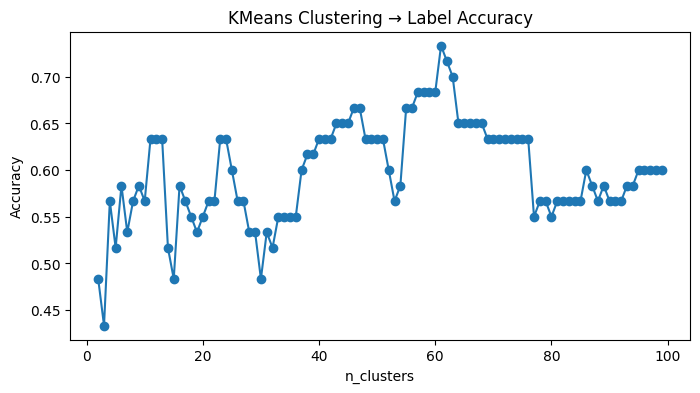

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assume cleaned_data ndarray with last column = true labels
X = cleaned_data
y = labels.astype(int)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

accuracy_vals = []
cluster_range = range(2, 100)

for k in cluster_range:
    # 1) fit
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)
    train_clusters = kmeans.labels_
    
    # 2) build mapping from cluster → most frequent true label
    mapping = {}
    for c in np.unique(train_clusters):
        mask = (train_clusters == c)
        # among y_train[mask], pick most common label
        mapping[c] = np.bincount(y_train[mask]).argmax()
    
    # 3) predict on X_test
    test_clusters = kmeans.predict(X_test)
    y_pred = np.array([ mapping[c] for c in test_clusters ])
    
    # 4) score
    acc = accuracy_score(y_test, y_pred)
    accuracy_vals.append(acc)
    print(f"{k}-cluster KMeans accuracy: {acc:.2%}")

# visualize
plt.figure(figsize=(8,4))
plt.plot(list(cluster_range), accuracy_vals, marker='o')
plt.xlabel("n_clusters")
plt.ylabel("Accuracy")
plt.title("KMeans Clustering → Label Accuracy")
plt.show()


KMEANS on PCA

2-cluster KMeans accuracy: 48.33%
3-cluster KMeans accuracy: 43.33%
4-cluster KMeans accuracy: 56.67%
5-cluster KMeans accuracy: 51.67%
6-cluster KMeans accuracy: 55.00%
7-cluster KMeans accuracy: 56.67%
8-cluster KMeans accuracy: 51.67%
9-cluster KMeans accuracy: 50.00%
10-cluster KMeans accuracy: 51.67%
11-cluster KMeans accuracy: 53.33%
12-cluster KMeans accuracy: 53.33%
13-cluster KMeans accuracy: 60.00%
14-cluster KMeans accuracy: 58.33%
15-cluster KMeans accuracy: 61.67%
16-cluster KMeans accuracy: 55.00%
17-cluster KMeans accuracy: 58.33%
18-cluster KMeans accuracy: 58.33%
19-cluster KMeans accuracy: 65.00%
20-cluster KMeans accuracy: 61.67%
21-cluster KMeans accuracy: 51.67%
22-cluster KMeans accuracy: 48.33%
23-cluster KMeans accuracy: 58.33%
24-cluster KMeans accuracy: 58.33%
25-cluster KMeans accuracy: 58.33%
26-cluster KMeans accuracy: 56.67%
27-cluster KMeans accuracy: 56.67%
28-cluster KMeans accuracy: 58.33%
29-cluster KMeans accuracy: 58.33%
30-cluster KMeans accuracy: 

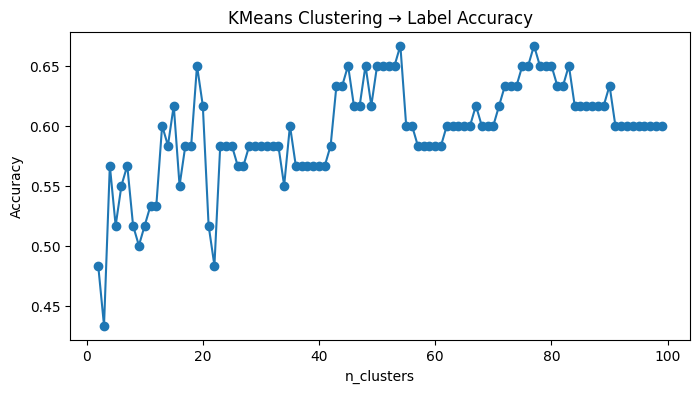

In [54]:
X = principal_components[:, :4]
y = labels.astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

accuracy_vals = []
cluster_range = range(2, 100)

for k in cluster_range:
    # 1) fit
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)
    train_clusters = kmeans.labels_
    
    # 2) build mapping from cluster → most frequent true label
    mapping = {}
    for c in np.unique(train_clusters):
        mask = (train_clusters == c)
        # among y_train[mask], pick most common label
        mapping[c] = np.bincount(y_train[mask]).argmax()
    
    # 3) predict on X_test
    test_clusters = kmeans.predict(X_test)
    y_pred = np.array([ mapping[c] for c in test_clusters ])
    
    # 4) score
    acc = accuracy_score(y_test, y_pred)
    accuracy_vals.append(acc)
    print(f"{k}-cluster KMeans accuracy: {acc:.2%}")

# visualize
plt.figure(figsize=(8,4))
plt.plot(list(cluster_range), accuracy_vals, marker='o')
plt.xlabel("n_clusters")
plt.ylabel("Accuracy")
plt.title("KMeans Clustering → Label Accuracy")
plt.show()

Naive Bayes

In [70]:
import numpy as np
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import train_test_split

# Assume cleaned_data and y are already defined.

# Split continuous and categorical columns
X_categorical_cols = [1, 2, 5, 8, 10, 12]
X_continuous_cols = [0, 3, 4, 6, 7, 9, 11]

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_data, y, test_size=0.2, random_state=42
)
print(cleaned_data.shape)
X_continuous_train = X_train[:, X_continuous_cols]
X_categorical_train = X_train[:, X_categorical_cols]
X_continuous_test = X_test[:, X_continuous_cols]
X_categorical_test = X_test[:, X_categorical_cols]

print(X_continuous_train.shape)
print(X_categorical_train.shape)
print(X_continuous_test.shape)
print(X_categorical_test.shape)

# Train models
gaussian_model = GaussianNB()
gaussian_model.fit(X_continuous_train, y_train)

categorical_model = CategoricalNB()
categorical_model.fit(X_categorical_train, y_train)

# Define prediction function
def predict_mixed_nb(X_continuous, X_categorical):
    print(X_continuous.shape)
    print(X_categorical.shape)
    print(categorical_model.n_categories_)
    
    gaussian_probs = gaussian_model.predict_proba(X_continuous)
    categorical_probs = categorical_model.predict_proba(X_categorical)
    
    combined_probs = gaussian_probs * categorical_probs
    normalized_probs = combined_probs / np.sum(combined_probs, axis=1, keepdims=True)
    return np.argmax(normalized_probs, axis=1)

# ---- Now predict on all data ----
predictions = predict_mixed_nb(X_continuous_test, X_categorical_test)

# Print the first few predictions
print(f"Predictions on test set: {predictions[:10]}")

acc = accuracy_score(y_test, predictions)
print(f"Accuracy: {acc:.4f}")

(297, 13)
(237, 7)
(237, 6)
(60, 7)
(60, 6)
(60, 7)
(60, 6)
[2 5 2 2 4 8]
Predictions on test set: [0 0 0 1 0 0 0 0 1 0]
Accuracy: 0.8833


XG boost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X = cleaned_data
y = labels.astype(int)

base_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'gamma': [0, 1]
}

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',      
    cv=3,                    
    verbose=1,
    n_jobs=-1                
)


grid_search.fit(X[:-30], y[:-30])

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2%}")


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X[-30:])
acc = accuracy_score(y[-30:], y_pred)

print(f"Final XGBoost accuracy on test set: {acc:.2%}")
